In [1]:
%matplotlib inline
import tarfile
import numpy as np
import pandas as pd
import pickle
import os,random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
#from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
os.environ["THEANO_FLAGS"]  = "device=gpu%d" %(1)
os.environ["THEANO_FLAGS"]  = "floatX=float32,device=gpu,nvcc.flags=-D_FORCE_INLINES"

Using TensorFlow backend.


In [2]:
#tar = tarfile.open("RML2016.10a.tar.bz2", "r:bz2")  
#tar.extractall()
#tar.close()

In [3]:
f = open('RML2016.10a_dict.pkl','rb')
t = pickle.load(f,encoding = 'latin1')

In [4]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs = sorted(list(set([k[1] for k,v in t.items()])), reverse = True)
mods = list(set([k[0] for k,v in t.items()]))

In [5]:
print('These are the modulation schemes in the dataset:\n')
for i in mods:
    #print(i)
    pass

These are the modulation schemes in the dataset:



In [6]:
print('These are the signal to noise ratios in the dataset:')
for i in snrs:
    #print(i)
    pass

These are the signal to noise ratios in the dataset:


In [7]:
np.shape(t['QAM64', 0])

(1000, 2, 128)

In [8]:
#Compute the original RF signal from the I & Q components.

def reconstructSignal(x):
    I = x[0,:]   # I component
    Q = x[1,:]   # Q component
    n = len(I)   # number of samples
    f = 10e6     # Carrier frequency
    return I * np.cos(2 * np.pi * f *np.arange(n)) + Q * np.sin(2 * np.pi * f * np.arange(n))

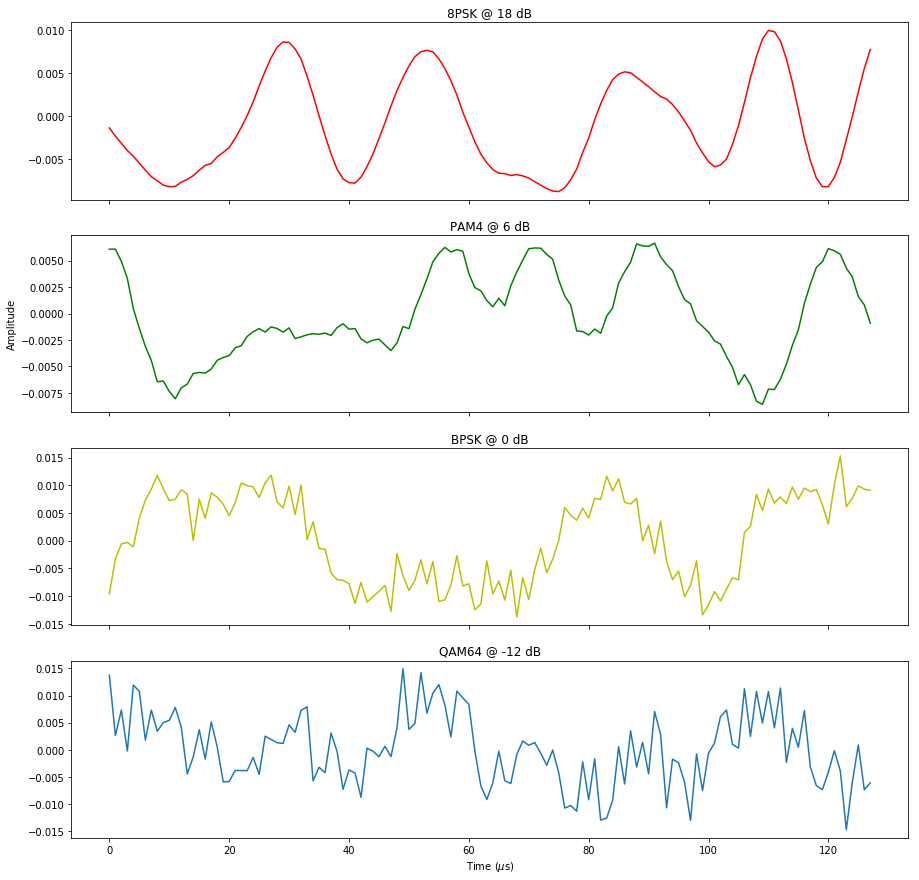

In [9]:
# Plot some of the data
nFigs = 4

plt.figure(figsize = (15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(t['8PSK', 18][2,:,:]), color = 'r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex = ax1);
plt.plot(reconstructSignal(t['PAM4', 6][99,:,:]), color = 'g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex = ax1)
plt.plot(reconstructSignal(t['BPSK', 0][500,:]), color = 'y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex = ax1)
plt.plot(reconstructSignal(t['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible = False)
plt.setp(ax2.get_xticklabels(), visible = False)
plt.setp(ax1.get_xticklabels(), visible = False)

plt.xlabel(r'Time ($\mu$s)');

In [10]:
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(t[(mod,snr)])
        for i in range(t[(mod,snr)].shape[0]):  
            lbl.append((mod,snr))
X = np.vstack(X)

In [11]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(42)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)  # Why a 50/50 split instead of 60/40 or 70/30??
train_idx = np.random.choice(range(0,n_examples), size = n_train, replace = False)
test_idx = list(set(range(0,n_examples)) - set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [12]:
#def train_valid_test(x, train_pct = 0.8, test_pct = 0.6):
    #index = np.random.choice(range(0,len(x)), size = len(x), replace = False)
    #tr = int(len(index) * train_pct)
    #ts = int(len(index) * test_pct)
    #train = index[:ts]
    #valid = index[ts:tr]
    #test = index[tr:]
    #return train, valid, test

In [13]:
y_tr = np.array(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
y_ts = np.array(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [14]:
y_train = pd.get_dummies(y_tr).values
y_test = pd.get_dummies(y_ts).values

In [15]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (110000, 2, 128)
Test set is (110000, 2, 128)


In [20]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print (X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [21]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = Sequential()  # Neural network is a set of sequential layers
model.add(Reshape(in_shp + [1], input_shape = in_shp))  
model.add(Conv2D(256, (1, 3), activation = "relu",kernel_initializer = 'glorot_uniform'))
model.add(ZeroPadding2D((0, 2)))  # Add 2 columns of zeros to each side
model.add(Dropout(dr))
model.add(Conv2D(80, (2, 3), activation="relu", kernel_initializer = 'glorot_uniform'))
model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, kernel_initializer = "he_normal", activation="relu"))
model.add(Dropout(dr))
model.add(Dense(len(classes),activation = 'softmax', kernel_initializer = 'he_normal'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 126, 256)       1024      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 2, 130, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 128, 80)        122960    
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 1, 132, 80)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 132, 80)        0         
__________

In [22]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [23]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = nb_epoch, verbose = 1, validation_data = (X_test,y_test),
    callbacks = [
       keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto'),
       keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0, mode = 'auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
110000/110000 [==============================] - 35s 320us/step - loss: 2.2453 - acc: 0.1521 - val_loss: 2.0963 - val_acc: 0.2207
Epoch 2/100
110000/110000 [==============================] - 33s 299us/step - loss: 2.0266 - acc: 0.2498 - val_loss: 1.8990 - val_acc: 0.2882
Epoch 3/100
110000/110000 [==============================] - 33s 299us/step - loss: 1.9029 - acc: 0.2855 - val_loss: 1.7996 - val_acc: 0.3221
Epoch 4/100
110000/110000 [==============================] - 33s 300us/step - loss: 1.8086 - acc: 0.3208 - val_loss: 1.6833 - val_acc: 0.3714
Epoch 5/100
110000/110000 [==============================] - 33s 301us/step - loss: 1.7111 - acc: 0.3603 - val_loss: 1.5911 - val_acc: 0.4183
Epoch 6/100
110000/110000 [==============================] - 33s 301us/step - loss: 1.6384 - acc: 0.3856 - val_loss: 1.5315 - val_acc: 0.4339
Epoch 7/100
110000/110000 [==============================] - 33s 301us/step - loss: 1.5815 - acc

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0, batch_size = batch_size)

In [ ]:
print(score[1] * 100)

In [ ]:
# Show loss curves 
plt.figure(figsize = (12,8))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label ='train_error')
plt.plot(history.epoch, history.history['val_loss'], label ='val_error')
legend = plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title = 'Confusion matrix', cmap = plt.cm.Blues, labels = []):
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot confusion matrix
plt.figure(figsize = (12,8))
test_Y_hat = model.predict(X_test, batch_size = batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels = classes)

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], valid))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = y_test[np.where(np.array(test_SNRs)==snr)] 
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title = "ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
print(acc)
#fd = open('results_cnn2_d0.5.dat','wb')
#cPickle.dump( ("CNN2", 0.5, acc) , fd )

In [ ]:
# Plot accuracy curve
plt.figure(figsize = (12,8))
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plot = plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")